# Data Preprocessing

In [44]:
# Load the CSV file
import pandas as pd

df = pd.read_csv('COVID-19.csv', encoding='latin1')

df = df.astype(str)

In [45]:
df

,tweets.created_at,tweets.text
0,2021/5/20 07:10,UGC in Bangladesh gives green light to online ...
1,2021/5/19 15:32,Skilling for the future is the way to fight gr...
2,2021/5/20 07:10,Pfizer vaccine after AstraZeneca dose is highl...
3,2021/5/19 18:40,Pfizer Covid vaccine can now be stored at frid...
4,2021/5/19 19:45,India's official coronavirus tally crosses gri...
...,...,...
53556,2021/5/18 11:10,Every family that has had a death due to #COVI...
53557,2021/5/18 11:10,Pandemic-specific training requirements includ...
53558,2021/5/18 11:10,The SARS-CoV-2 (#COVID19) pandemic has raised ...
53559,2021/5/18 11:10,Whether it's plankton exposed to parasites or ...


In [46]:
# Data cleaning
import re
import numpy as np

def process_tweet(tweet):
    tweet = tweet.lower()                                             #Lowercases the string
    tweet = re.sub('@[^\s]+', " ", tweet)                             #Remove the '@'
    tweet = re.sub('#[^\s]+', " ", tweet)                             #Remove the tags
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', " ", tweet)   #Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           #Remove digits
    tweet = re.sub(r"\b[a-zA-Z]\b", " ", str(tweet))                  #Remove single characters
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       #Remove punctuations
    tweet = re.sub(r"\s+", " ", str(tweet))                           #Replace to single space
    return tweet

df['processed_tweet'] = np.vectorize(process_tweet)(df['tweets.text'])

In [47]:
# Stop words
from nltk.corpus import stopwords

stop = stopwords.words('english')

df['processed_tweet'] = df['processed_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Sentiment Scoring and Labeling

In [48]:
# Sentiment analysis (Vader lexicon)
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

scores = []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []

for i in range(df['processed_tweet'].shape[0]):
    compound = analyzer.polarity_scores(df['processed_tweet'][i])["compound"]
    pos = analyzer.polarity_scores(df['processed_tweet'][i])["pos"]
    neu = analyzer.polarity_scores(df['processed_tweet'][i])["neu"]
    neg = analyzer.polarity_scores(df['processed_tweet'][i])["neg"]
    
    scores.append({"Vader_Score": compound})
    
Vader_score = pd.DataFrame.from_dict(scores)
df2 = df.join(Vader_score)

In [49]:
# Vader lexicon sentiment score range 1 to -1
df2.loc[df2['Vader_Score'] > 0, 'Vader_Sentiment'] = 'Positive'
df2.loc[df2['Vader_Score'] < 0, 'Vader_Sentiment'] = 'Negative'
df2.loc[df2['Vader_Score'] == 0, 'Vader_Sentiment'] = 'Neutral'

In [50]:
# Sentiment analysis (Afinn lexicon)
from afinn import Afinn

af = Afinn()

sentiment_scores = [af.score(i) for i in df['processed_tweet']]

df2['Afinn_Score'] = sentiment_scores

In [51]:
# Afinn lexicon sentiment score range unimlited increase or dcrease
sentiment = ['Positive' if score > 0
                          else 'Negative' if score < 0
                              else 'Neutral'
                                  for score in sentiment_scores]

df2['Afinn_Sentiment'] = sentiment

In [52]:
df2 = df2.drop(['tweets.created_at'], axis=1)

In [53]:
import plotly.express as px

a = pd.DataFrame({'Lexicon': ['Vader_Sentiment','Afinn_Sentiment'], 
                  'Positive': [(df2.Vader_Sentiment == 'Positive').sum(), (df2.Afinn_Sentiment == 'Positive').sum()],
                  'Negative': [(df2.Vader_Sentiment == 'Negative').sum(), (df2.Afinn_Sentiment == 'Negative').sum()],
                  'Neutral': [(df2.Vader_Sentiment == 'Neutral').sum(), (df2.Afinn_Sentiment == 'Neutral').sum()]})

fig = px.bar(a, x="Lexicon", y=["Positive", "Negative", "Neutral"], barmode="group"
             , title="Vader lexicon and Afinn lexicon performance")
fig.show()

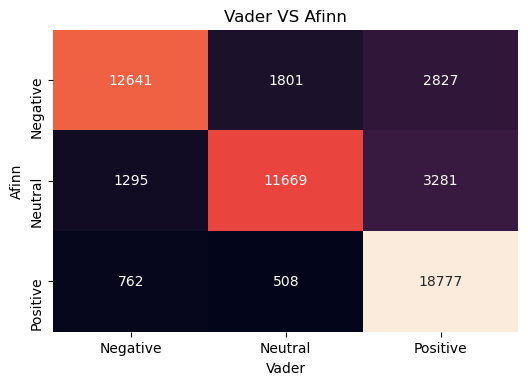

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

x_axis_labels = ['Negative', 'Neutral', 'Positive']
y_axis_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(dpi=100)
mat = confusion_matrix(df2['Vader_Sentiment'], df2['Afinn_Sentiment'])
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

plt.xlabel('Vader')
plt.ylabel('Afinn')
plt.title('Vader VS Afinn')
plt.show()

In [55]:
# Keep the same sentiment in both lexicon
df2.loc[(df2['Vader_Sentiment'] == 'Positive') & (df2['Afinn_Sentiment'] == 'Positive'), 'verify_sentiment'] = 'Positive'
df2.loc[(df2['Vader_Sentiment'] == 'Negative') & (df2['Afinn_Sentiment'] == 'Negative'), 'verify_sentiment'] = 'Negative'
df2.loc[(df2['Vader_Sentiment'] == 'Neutral') & (df2['Afinn_Sentiment'] == 'Neutral'), 'verify_sentiment'] = 'Neutral'

In [56]:
# Drop the nan column
df2 = df2.dropna()

In [57]:
# Reset df2 index
df2 = df2.reset_index(drop=True)

In [58]:
df2

,tweets.text,processed_tweet,Vader_Score,Vader_Sentiment,Afinn_Score,Afinn_Sentiment,verify_sentiment
0,UGC in Bangladesh gives green light to online ...,ugc bangladesh gives green light online exams ...,0.0000,Neutral,0.0,Neutral,Neutral
1,Pfizer vaccine after AstraZeneca dose is highl...,pfizer vaccine astrazeneca dose highly safe ef...,0.7630,Positive,3.0,Positive,Positive
2,Pfizer Covid vaccine can now be stored at frid...,pfizer covid vaccine stored fridge temperature...,0.0000,Neutral,0.0,Neutral,Neutral
3,India's official coronavirus tally crosses gri...,india official coronavirus tally crosses grim ...,-0.5719,Negative,-2.0,Negative,Negative
4,Singapore rebuts an Indian chief minister who ...,singapore rebuts indian chief minister sounded...,-0.3400,Negative,-2.0,Negative,Negative
...,...,...,...,...,...,...,...
43082,Brits typically spent 78 a month on #takeawa...,brits typically spent month tv alcohol due,0.0000,Neutral,0.0,Neutral,Neutral
43083,Building projects that invest in communitiesf...,building projects invest communities innovativ...,0.8442,Positive,6.0,Positive,Positive
43084,Every family that has had a death due to #COVI...,every family death due among given rs ex grati...,-0.5994,Negative,-2.0,Negative,Negative
43085,Pandemic-specific training requirements includ...,pandemic specific training requirements includ...,0.0000,Neutral,0.0,Neutral,Neutral


# Classification

In [59]:
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))
final_vectorized_data = vectorizer.fit_transform(df2.processed_tweet)  
final_vectorized_data

<43087x345471 sparse matrix of type '<class 'numpy.int64'>'
	with 1067833 stored elements in Compressed Sparse Row format>

In [61]:
# Split train set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, df2['verify_sentiment'], 
                                                    test_size=0.3, random_state=42)

## Naive Bayes Classifier

In [62]:
from sklearn.naive_bayes import MultinomialNB

start = time.time()

model_naive = MultinomialNB().fit(X_train, y_train)
predicted_naive = model_naive.predict(X_test)

end = time.time()
time_naive = (end - start)

In [63]:
# Model accuracy
score_naive = accuracy_score(y_test, predicted_naive)
print("Naive Bayes Accuracy: ", score_naive)

Naive Bayes Accuracy:  0.7809236481782316


In [64]:
print("Naive Bayes Classification Report \n")
print(classification_report(y_test, predicted_naive))

Naive Bayes Classification Report 

              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      3771
     Neutral       0.87      0.54      0.67      3495
    Positive       0.75      0.91      0.82      5661

    accuracy                           0.78     12927
   macro avg       0.80      0.75      0.76     12927
weighted avg       0.79      0.78      0.77     12927



## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

start = time.time()

model_log = LogisticRegression(max_iter=3000).fit(X_train, y_train)
predicted_log = model_log.predict(X_test)

end = time.time()
time_log = (end - start)

In [66]:
# Model accuracy
score_log = accuracy_score(y_test, predicted_log)
print("Logistic Regression Accuracy: ",score_log)

Logistic Regression Accuracy:  0.905237100642067


In [67]:
print("Logistic Regression Classification Report \n")
print(classification_report(y_test, predicted_log))

Logistic Regression Classification Report 

              precision    recall  f1-score   support

    Negative       0.95      0.84      0.89      3771
     Neutral       0.81      0.96      0.88      3495
    Positive       0.95      0.91      0.93      5661

    accuracy                           0.91     12927
   macro avg       0.90      0.91      0.90     12927
weighted avg       0.91      0.91      0.91     12927



## Linear Support Vector Classifier

In [68]:
from sklearn.svm import LinearSVC

start = time.time()

model_svc = LinearSVC(max_iter=3000).fit(X_train, y_train)
predicted_svc = model_svc.predict(X_test)

end = time.time()
time_svc = (end - start)

In [69]:
# Model accuracy
score_svc = accuracy_score(y_test,predicted_svc)
print("Linear Support Vector Accuracy: ", score_svc)

Linear Support Vector Accuracy:  0.9176916531291096


In [70]:
print("Linear Support Vector Classification Report \n")
print(classification_report(y_test, predicted_svc))

Linear Support Vector Classification Report 

              precision    recall  f1-score   support

    Negative       0.96      0.85      0.90      3771
     Neutral       0.83      0.98      0.90      3495
    Positive       0.96      0.93      0.94      5661

    accuracy                           0.92     12927
   macro avg       0.92      0.92      0.91     12927
weighted avg       0.92      0.92      0.92     12927



# Classification Result

In [71]:
f1_naive = f1_score(y_test,predicted_naive, average = None)*100
f1_log = f1_score(y_test,predicted_log, average = None)*100
f1_svc = f1_score(y_test,predicted_svc, average = None)*100

models_f1 = pd.DataFrame({'Naive Bayes':f1_naive, 'Logistic Regression':f1_log, 'Linear Support Vector':f1_svc}, index=['Negative', 'Neutral', 'Positive']).T

In [72]:
fig_f1 = px.bar(models_f1, y=["Positive", "Negative", "Neutral"], barmode="group" , title="F1 score")
fig_f1.show()

In [73]:
models = pd.DataFrame({'Model': ['Naive Bayes Classifier', 'Logistic Regression', 'Linear Support Vector Classifier']
                       , 'Accuracy': [score_naive*100, score_log*100, score_svc*100]
                       , 'Precision': [precision_score(y_test,predicted_naive, average = "macro")*100, precision_score(y_test,predicted_log, average = "macro")*100, precision_score(y_test,predicted_svc, average = "macro")*100]
                       , 'Recall': [recall_score(y_test,predicted_naive, average = "macro")*100, recall_score(y_test,predicted_log, average = "macro")*100, recall_score(y_test,predicted_svc, average = "macro")*100]
                       , 'F1': [f1_score(y_test,predicted_naive, average = "macro")*100, f1_score(y_test,predicted_log, average = "macro")*100, f1_score(y_test,predicted_svc, average = "macro")*100]
                       , 'Time (seconds)': [time_naive, time_log, time_svc]})

In [74]:
fig = px.bar(models, x="Model", y=["Accuracy", "Precision", "Recall", "F1"]
             , barmode="group" , title="Classifier performance")
fig.show()

In [75]:
models.sort_values(by='Accuracy', ascending=False).round(3)

,Model,Accuracy,Precision,Recall,F1,Time (seconds)
2,Linear Support Vector Classifier,91.769,91.552,91.767,91.334,25.637
1,Logistic Regression,90.524,90.307,90.519,90.082,27.201
0,Naive Bayes Classifier,78.092,80.373,75.366,76.264,0.122


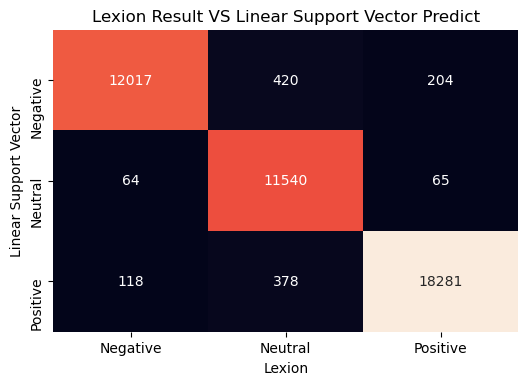

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

predict_tweets = np.array(df2['processed_tweet'])
result = vectorizer.transform(predict_tweets)
result = model_log.predict(result)

x_axis_labels = ['Negative', 'Neutral', 'Positive']
y_axis_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(dpi=100)
mat = confusion_matrix(result, df2['verify_sentiment'])
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

plt.xlabel('Lexion')
plt.ylabel('Linear Support Vector')
plt.title('Lexion Result VS Linear Support Vector Predict')
plt.show()

# Prediction

In [77]:
unlable_df = pd.read_csv('COVID19_predict.csv', encoding='latin1')
unlable_df = unlable_df.astype(str)

In [78]:
unlable_df['processed_tweet'] = np.vectorize(process_tweet)(unlable_df['tweets.text'])
unlable_df['processed_tweet'] = unlable_df['processed_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [79]:
predict_new_text = np.array(unlable_df['processed_tweet'])
result = vectorizer.transform(predict_new_text)
result = model_log.predict(result)

In [80]:
sentiments_prediction = pd.DataFrame.from_dict(result)
predict_df = unlable_df.join(sentiments_prediction)

In [81]:
predict_df

,tweets.created_at,tweets.text,processed_tweet,0
0,2021/4/24 14:39,FREE HOME COOKED MEALS\r\nFOR COVID PATIENTS\r...,free home cooked meals covid patients sector n...,Positive
1,2021/4/24 13:38,#CovidIndia #Verified #Lucknow #Oxygen \r\n\r\...,contact service available oxygen city lucknow ...,Neutral
2,2021/4/24 08:02,Sunrise Hospital\r\n\r\nOxygen beds Available...,sunrise hospital oxygen beds available details...,Neutral
3,2021/4/24 07:21,Allahabad\r\n\r\nContact number: 8726772225\r\...,allahabad contact number refilling cylinders v...,Neutral
4,2021/4/24 05:15,"Beds availability: Sardar Patel COVID Centre, ...",beds availability sardar patel covid centre de...,Neutral
...,...,...,...,...
17988,2021/4/24 03:01,@mlaAminPatel @CMOMaharashtra @OfficeofUT @Rah...,good initiative lets hope mlas mps follow ur path,Positive
17989,2021/4/24 03:01,I urge Muslims all over the world to pray for ...,urge muslims world pray people india may god h...,Negative
17990,2021/4/24 03:01,My wifefs grandfather has succumbed to #COVID...,wife fs grandfather succumbed man dignity calm...,Negative
17991,2021/4/24 03:01,@TGAgovau @GregHuntMP #COVID19 \r\n\r\nMedical...,medically safe effective,Positive


# Visualization

In [82]:
# Count each tweet's number of words
df2['Number_of_words'] = df2.processed_tweet.apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Total words of each emotion')

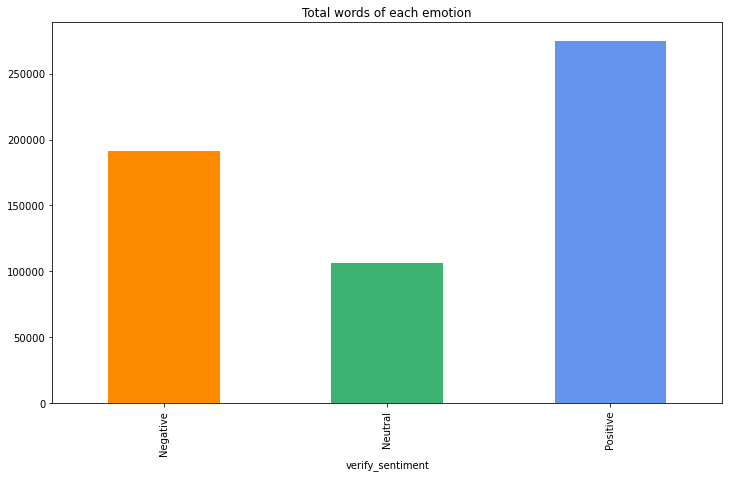

In [83]:
t = df2.groupby(['verify_sentiment'])['Number_of_words'].sum()

t.plot(kind='bar', figsize=(12,7), color= ['darkorange', 'mediumseagreen', 'cornflowerblue'])
plt.title('Total words of each emotion')

{'Neutral': 11669, 'Positive': 18777, 'Negative': 12641}


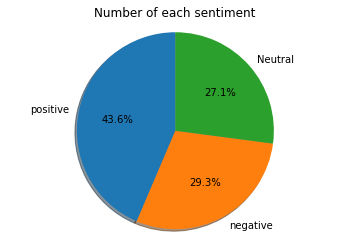

In [84]:
import matplotlib.pyplot as plotter
from matplotlib import pyplot as plt
from collections import Counter

c = dict(Counter(df2['verify_sentiment']))

print ({key:value for key,value in c.items()if value > 1}) 

labels = 'positive', 'negative', 'Neutral'

fig1, ax1 = plt.subplots()
ax1.pie(df2['verify_sentiment'].value_counts(), labels = labels, autopct = '%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Number of each sentiment')
plt.show()

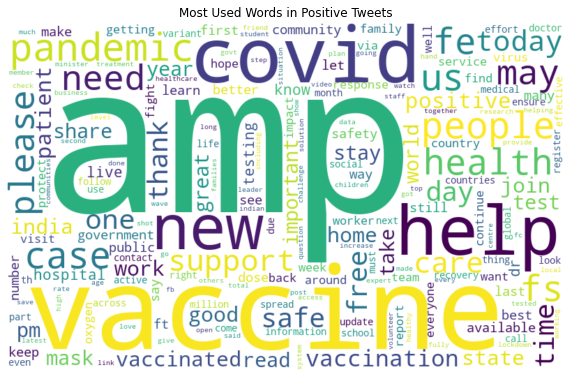

In [85]:
# WordCloud
from wordcloud import  WordCloud

text = " ".join(review for review in df2.loc[df2['verify_sentiment'] == 'Positive', 'processed_tweet'])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=21, max_font_size=300, 
                      background_color="white").generate(text)
fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Used Words in Positive Tweets')
plt.show()

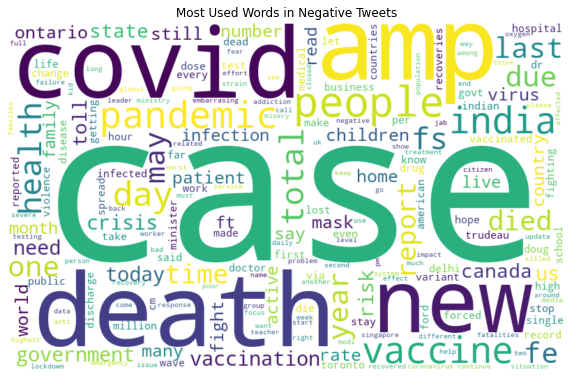

In [86]:
text = " ".join(review for review in df2.loc[df2['verify_sentiment'] == 'Negative', 'processed_tweet'])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=21, max_font_size=300, 
                      background_color="white").generate(text)
fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Used Words in Negative Tweets')
plt.show()